# Testing
### Nationalität und Geburtsland der Bewohnenden nach Gebäudeeigentum und Stadtquartieren in der Stadt Zürich seit 2008

Diese Daten zeigen die Personen nach Nationalität und Geburtsland nach Stadtquartier und Gebäude-Eigentumsgruppe in der Stadt Zürich. Die Daten liegen ab dem Jahr 2008 jährlich vor.

Datum: 15.03.2022

### Importiere die notwendigen Packages

In [24]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [25]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import seaborn as sns


import requests
import io

In [26]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [27]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [28]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [29]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [30]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 3 datenstand:  1 time.struct_time(tm_year=2022, tm_mon=3, tm_mday=15, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=74, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [31]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [32]:
package_name = "bau_best_geb_ea_pers_nat_gebland_quartier_jahr_od6984"

In [33]:
dataset_name = "BAU698OD6984.csv"

**Statische Pfade in DWH-Dropzones**

In [34]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [35]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [36]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [37]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [38]:
from IPython.display import Markdown as md

In [39]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_best_geb_ea_pers_nat_gebland_quartier_jahr_od6984 

In [40]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bau_best_geb_ea_pers_nat_gebland_quartier_jahr_od6984 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [41]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [42]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_best_geb_ea_pers_nat_gebland_quartier_jahr_od6984/download/BAU698OD6984.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [43]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr    datetime64[ns]
QuarSort18                  int64
QuarLang18                 object
KreisSort                   int64
KreisLang                  object
EigGruSort                  int64
EigGruLang                 object
AnzGebMitPers               int64
PersTotal                   int64
NatCHGebCH                  int64
NatCHGebAu                  int64
NatAuGebCH                  int64
NatAuGebAu                  int64
dtype: object

Berechne weitere Attribute falls notwendig

In [44]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
QuarSort18                      int64
QuarLang18                     object
KreisSort                       int64
KreisLang                      object
EigGruSort                      int64
EigGruLang                     object
AnzGebMitPers                   int64
PersTotal                       int64
NatCHGebCH                      int64
NatCHGebAu                      int64
NatAuGebCH                      int64
NatAuGebAu                      int64
StichtagDatJahr_str            object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [45]:
#data2betested.head(6)

In [46]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
QuarSort18                      int64
QuarLang18                     object
KreisSort                       int64
KreisLang                      object
EigGruSort                      int64
EigGruLang                     object
AnzGebMitPers                   int64
PersTotal                       int64
NatCHGebCH                      int64
NatCHGebAu                      int64
NatAuGebCH                      int64
NatAuGebAu                      int64
StichtagDatJahr_str            object
dtype: object

In [47]:
data2betested.shape

(1624, 14)

Beschreibe einzelne Attribute

In [48]:
data2betested.describe()

,QuarSort18,KreisSort,EigGruSort,AnzGebMitPers,PersTotal,NatCHGebCH,NatCHGebAu,NatAuGebCH,NatAuGebAu
count,1624,1624,1624,1624,1624,1624,1624,1624,1624
mean,69,7,2,310,3517,1944,459,152,962
std,35,3,1,288,2754,1544,384,148,839
min,10,1,1,6,118,59,17,0,23
25%,41,4,2,102,1313,732,161,41,295
50%,71,7,2,204,2726,1299,356,101,714
75%,101,10,3,424,5677,3109,659,222,1388
max,123,12,4,1274,12181,6206,2095,833,4330


Wie viele Nullwerte gibt es im Datensatz?

In [49]:
data2betested.isnull().sum()

StichtagDatJahr        0
QuarSort18             0
QuarLang18             0
KreisSort              0
KreisLang              0
EigGruSort             0
EigGruLang             0
AnzGebMitPers          0
PersTotal              0
NatCHGebCH             0
NatCHGebAu             0
NatAuGebCH             0
NatAuGebAu             0
StichtagDatJahr_str    0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [50]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [51]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1624 entries, 2021-01-01 to 2008-01-01
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   QuarSort18           1624 non-null   int64 
 1   QuarLang18           1624 non-null   object
 2   KreisSort            1624 non-null   int64 
 3   KreisLang            1624 non-null   object
 4   EigGruSort           1624 non-null   int64 
 5   EigGruLang           1624 non-null   object
 6   AnzGebMitPers        1624 non-null   int64 
 7   PersTotal            1624 non-null   int64 
 8   NatCHGebCH           1624 non-null   int64 
 9   NatCHGebAu           1624 non-null   int64 
 10  NatAuGebCH           1624 non-null   int64 
 11  NatAuGebAu           1624 non-null   int64 
 12  StichtagDatJahr_str  1624 non-null   object
dtypes: int64(9), object(4)
memory usage: 177.6+ KB


Int64Index([1], dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [52]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [56]:
data2betested.loc["2008":"2021"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort18,QuarLang18,KreisSort,KreisLang,EigGruSort,EigGruLang,AnzGebMitPers,PersTotal,NatCHGebCH,NatCHGebAu,NatAuGebCH,NatAuGebAu,StichtagDatJahr_str
StichtagDatJahr,,,,,,,,,,,,,
2021-01-01,123,Hirzenbach,12,Kreis 12,4,Im Stockwerkeigentum,20,538,228,120,37,153,2021-01-01
2021-01-01,21,Wollishofen,2,Kreis 2,1,Öffentlich/Genossenschaftlich,575,7176,4686,1167,257,1066,2021-01-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Quartier Anzahl Bewohner 60-69

In [57]:
myAgg = data2betested.loc["2008":"2021"]\
    .groupby(['StichtagDatJahr', 'EigGruSort', 'EigGruLang']) \
    .agg(sum_PersTotal=('PersTotal', 'sum'), sum_NatCHGebCH=('NatCHGebCH', 'sum'), sum_NatAuGebAu=('NatAuGebAu', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,EigGruSort,EigGruLang,sum_PersTotal,sum_NatCHGebCH,sum_NatAuGebAu
0,2008-01-01,1,Öffentlich/Genossenschaftlich,111566,68919,21058
1,2008-01-01,2,Übrige private Gesellschaften,91361,48513,28145
2,2008-01-01,3,Natürliche Personen,150271,84134,43925


In [59]:
myTitle="Titel"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['EigGruLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_PersTotal > 1'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_PersTotal', axis=alt.Axis(title='Anz. Projektierte Gebäude'))
    , color=alt.Color('EigGruLang', legend=alt.Legend(title="Projektstatus", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'StichtagDatJahr', 'EigGruSort', 'EigGruLang','sum_PersTotal','sum_NatAuGebAu']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [60]:
data2betested.columns

Index(['QuarSort18', 'QuarLang18', 'KreisSort', 'KreisLang', 'EigGruSort', 'EigGruLang',
       'AnzGebMitPers', 'PersTotal', 'NatCHGebCH', 'NatCHGebAu', 'NatAuGebCH', 'NatAuGebAu',
       'StichtagDatJahr_str'],
      dtype='object')

In [66]:
myAggBar = data2betested.loc["2008":"2021"]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str', 'EigGruSort', 'EigGruLang']) \
    .agg(sum_PersTotal=('PersTotal', 'sum'), sum_NatCHGebCH=('NatCHGebCH', 'sum'), sum_NatAuGebAu=('NatAuGebAu', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 
myAggBar.reset_index().head(3)

,StichtagDatJahr,StichtagDatJahr_str,EigGruSort,EigGruLang,sum_PersTotal,sum_NatCHGebCH,sum_NatAuGebAu
0,2008-01-01,2008-01-01,1,Öffentlich/Genossenschaftlich,111566,68919,21058
1,2008-01-01,2008-01-01,2,Übrige private Gesellschaften,91361,48513,28145
2,2008-01-01,2008-01-01,3,Natürliche Personen,150271,84134,43925


In [62]:
#help(sns.catplot)     

In [63]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

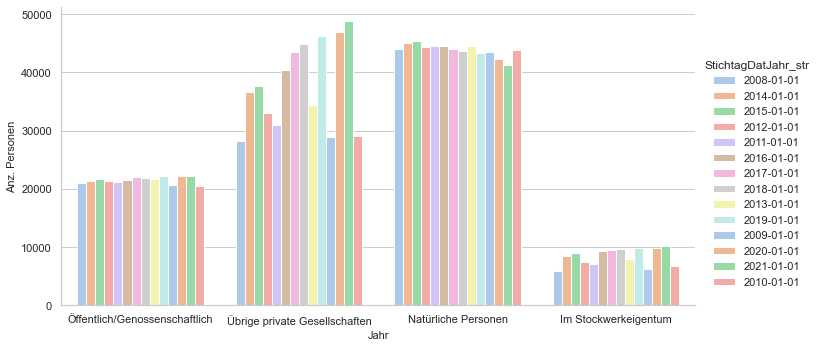

In [67]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="EigGruLang"
            , y="sum_NatAuGebAu"
            , hue="StichtagDatJahr_str"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.sort_values('EigGruSort', ascending=True).reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Personen', fontsize=11)


In [69]:
data2betested.columns

Index(['QuarSort18', 'QuarLang18', 'KreisSort', 'KreisLang', 'EigGruSort', 'EigGruLang',
       'AnzGebMitPers', 'PersTotal', 'NatCHGebCH', 'NatCHGebAu', 'NatAuGebCH', 'NatAuGebAu',
       'StichtagDatJahr_str'],
      dtype='object')

In [74]:
myAggBar = data2betested.loc["2008":"2021"]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str','KreisSort', 'KreisLang', 'EigGruSort', 'EigGruLang']) \
    .agg(sum_PersTotal=('PersTotal', 'sum')
         , sum_NatCHGebCH=('NatCHGebCH', 'sum')
         , sum_NatAuGebAu=('NatAuGebAu', 'sum')
         , sum_NatCHGebAu=('NatCHGebAu', 'sum')
         , sum_NatAuGebCH=('NatAuGebCH', 'sum')) \

myAggBar.reset_index().head(3)

,StichtagDatJahr,StichtagDatJahr_str,KreisSort,KreisLang,EigGruSort,EigGruLang,sum_PersTotal,sum_NatCHGebCH,sum_NatAuGebAu,sum_NatCHGebAu,sum_NatAuGebCH
0,2008-01-01,2008-01-01,1,Kreis 1,1,Öffentlich/Genossenschaftlich,1689,1310,156,191,32
1,2008-01-01,2008-01-01,1,Kreis 1,2,Übrige private Gesellschaften,1320,665,525,111,19
2,2008-01-01,2008-01-01,1,Kreis 1,3,Natürliche Personen,2117,1245,645,183,44


In [72]:
#myAggBar.reset_index()

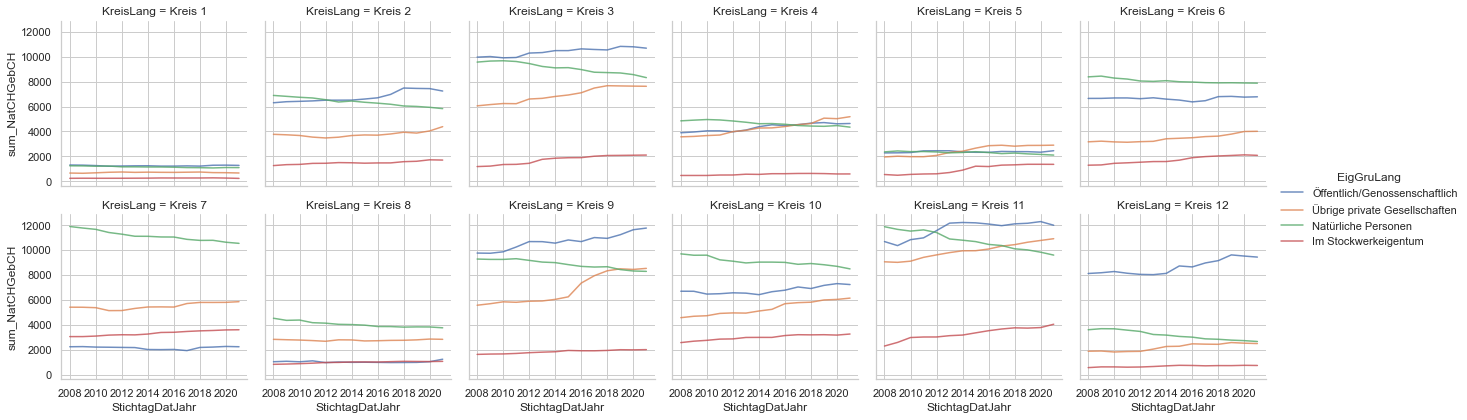

In [75]:
g = sns.FacetGrid(myAggBar.sort_values('KreisSort', ascending=True).reset_index(), col="KreisLang", hue="EigGruLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_ProjAnzWhg", alpha=.8)
g.map(sns.lineplot, "StichtagDatJahr","sum_NatCHGebCH",alpha=.8)

g.add_legend()

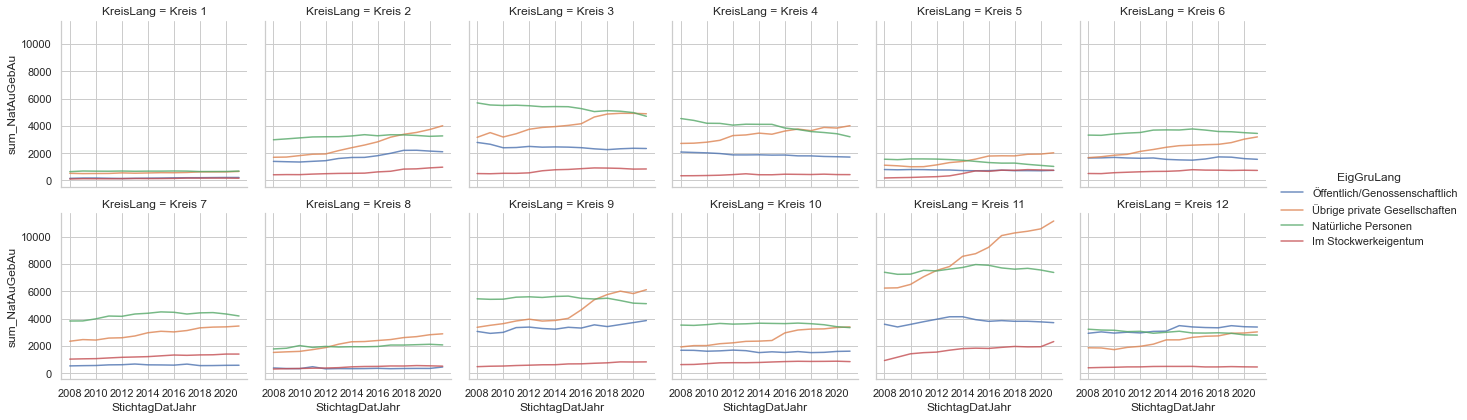

In [76]:
g2 = sns.FacetGrid(myAggBar.sort_values('KreisSort', ascending=True).reset_index(), col="KreisLang", hue="EigGruLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_ProjAnzWhg", alpha=.8)
g2.map(sns.lineplot, "StichtagDatJahr","sum_NatAuGebAu",alpha=.8)

g2.add_legend()

## ---------------------- hier Plausi beendet ---------------------- 

**Sharepoint als gecheckt markieren!**


Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=902&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------- 